# 06 — CNN Transfer Learning (MobileNetV2)

Obiettivo: migliorare la baseline CNN usando **transfer learning**.

Pipeline:
1. Carichiamo gli split dal DB (`train/val/test`).
2. Costruiamo `tf.data.Dataset` on-the-fly con resize+normalizzazione (+augmentation solo sul train).
3. Usiamo una rete pre-addestrata (ImageNet) come estrattore di feature.
4. (Opzionale) Fine-tuning degli ultimi layer.

> Nota: questo notebook usa i moduli in `src/garbagecls` (`db.py`, `paths.py`, `dataset.py`).

#### 0) Import + setup path + moduli src

In [1]:
import os
import sys
import json
from pathlib import Path
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- setup path: notebook sta in /notebooks -> root = parent ---
PROJECT_ROOT = Path.cwd().parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("TensorFlow:", tf.__version__)

from garbagecls.db import load_env, read_images_df, split_dfs
from garbagecls.dataset import build_label_maps, make_dataset


PROJECT_ROOT: c:\Users\simon\Documents\VSC\Progetto-Data-Science
TensorFlow: 2.20.0


#### 1) Carico i dati dal DB e preparo label_id con visulizzazione di prova

In [2]:
load_env()  # legge .env

df = read_images_df(source="raw_flat")  # oppure None se vuoi tutto
df_train, df_val, df_test = split_dfs(df)

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))
df_train.head()

# === Label mapping (coerente con gli altri notebook) ===
labels = sorted(df["label"].unique().tolist())
label2id, id2label = build_label_maps(df["label"].unique())

for d in (df_train, df_val, df_test):
    d["label_id"] = d["label"].map(label2id).astype("int32")

num_classes = len(label2id)
print("Classes:", num_classes, label2id, '\n')

print(df_train.head())

Train: 1768 Val: 379 Test: 380
Classes: 6 {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5} 

   image_id                                  filepath      label  split  \
0         1       data/raw_flat/plastic/plastic92.jpg    plastic  train   
1         2  data/raw_flat/cardboard/cardboard305.jpg  cardboard  train   
2         3   data/raw_flat/cardboard/cardboard53.jpg  cardboard  train   
3         4   data/raw_flat/cardboard/cardboard42.jpg  cardboard  train   
4         5          data/raw_flat/metal/metal141.jpg      metal  train   

   width  height  channels    source  label_id  
0    512     384         3  raw_flat         4  
1    512     384         3  raw_flat         0  
2    512     384         3  raw_flat         0  
3    512     384         3  raw_flat         0  
4    512     384         3  raw_flat         2  


c:\Users\simon\Documents\VSC\Progetto-Data-Science\src\garbagecls\db.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(base_query, conn, params=params if params else None)


#### 2) Creo i `tf.data.dataset` "raw" dai dataframe precedentemente creati  
Uso `make_dataset`:
- prende filepath e label_id
- legge file, decode, resize, normalizza [0,1] e applica augment solo su train

In [3]:
# === Hyperparameters ===
BATCH_SIZE = 32

# Per transfer learning conviene usare una risoluzione più "leggera".
# MobileNetV2 è spesso usata a 224x224. Manteniamo aspect ratio con resize_with_pad nel preprocessing (in dataset.py).
IMG_SIZE = (192, 256)  # (H, W) -> più leggero di 384x512 (farà resize_with_pad, più robusto per futuri caricamenti)
SEED = 42

EPOCHS_HEAD = 10
EPOCHS_FT = 5

LR_HEAD = 1e-3
LR_FT = 1e-5

UNFREEZE_LAST_N = 20

In [4]:
train_ds = make_dataset(
    df_train, training=True,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=True
)

val_ds = make_dataset(
    df_val, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

test_ds = make_dataset(
    df_test, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

(train_ds, val_ds, test_ds)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.042895734..1.0285014].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0052963].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17493448..1.007688].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0305936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0190014].


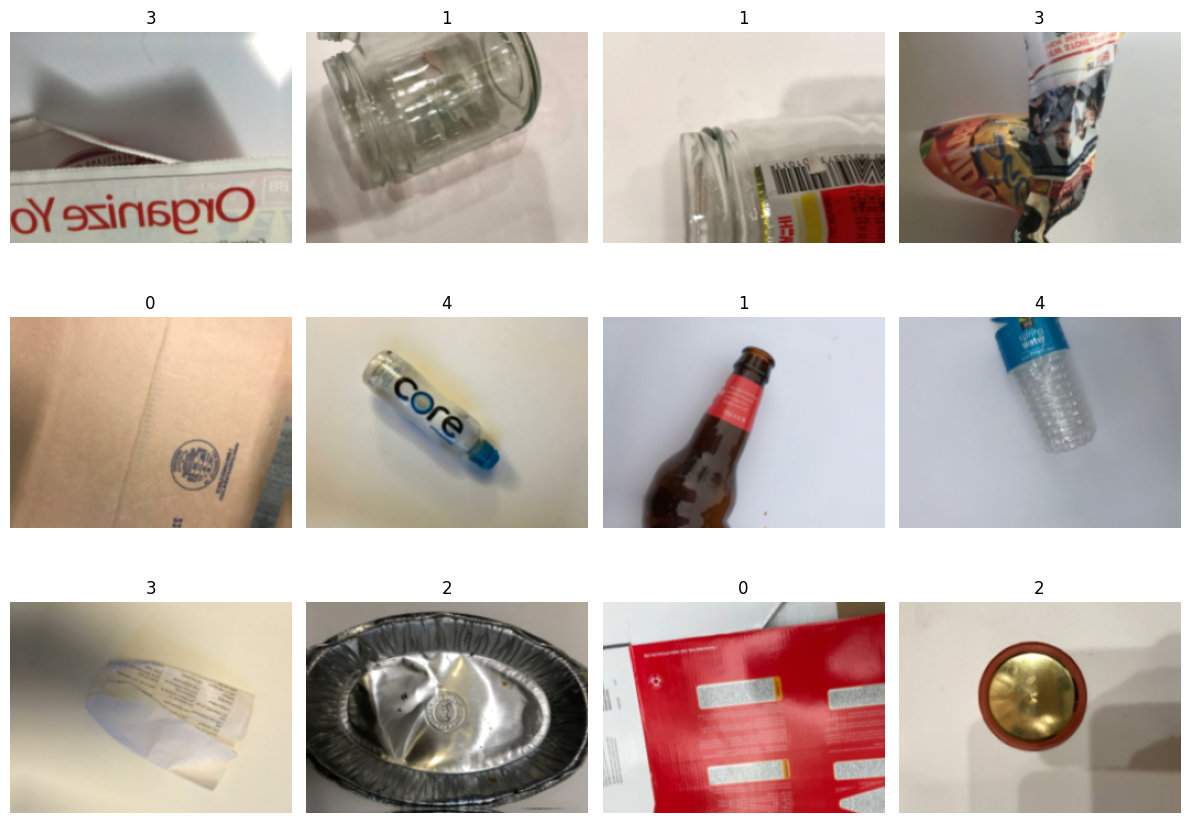

In [5]:
# Visualizziamo un batch di immagini


def show_batch(ds, n=12):
    x, y = next(iter(ds))
    x = x.numpy()
    y = y.numpy()

    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(12, 3*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x[i])
        plt.title(int(y[i]))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(train_ds, n=12)


#### 3) Preprocessing specifico per MobileNetV2  
In particolare `preprocess_input` di MobileNetV2 si aspetta pixel in [0,255] e li trasforma in [-1,1]

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

#### 4) Costruzione modello (backbone + head)  
La **base** è la CNN pre-addestrata su ImageNet. A partire da questa che non modifico (base-trainable = False) tolgo la parte finale (include_top=False)

In [7]:
# backbone pre-addestrato
base = keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base.trainable = False  # fase 1: solo head

inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# preprocessing integrato nel modello (perché MobileNetV2 si aspetta input preprocessati in un certo modo)
# input da make_dataset è in [0, 1], quindi moltiplichiamo per 255 e poi applichiamo preprocess_input
x = inputs * 255.0
x = preprocess_input(x)     # -> circa [-1, 1]
x = base(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x) # regolarizzazione, di fatto spegne il 30% dei neuroni a ogni step evitando di imparare scorciatoie (overfitting)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="mnv2_transfer")
model.summary()


C:\Users\simon\AppData\Local\Temp\ipykernel_8888\2162468821.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = keras.applications.MobileNetV2(


Model: "mnv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### 5) Training "head-only"  
Di fatto alleno solo i pesi di Dense finale perchè GAP (global_average_pooling) e dropout non hanno pesi

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR_HEAD),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# informazioni per salvataggio modelli
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True)
STAMP = datetime.now().strftime("%Y-%m%d-%H%M")

best_head_path = MODELS_DIR / f"cnn_transfer_mnv2_head_best_{STAMP}.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=best_head_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks
)

print()
test_loss_head, test_acc_head = model.evaluate(test_ds, verbose=1)
print(f"[HEAD] Test acc: {test_acc_head:.4f} | Test loss: {test_loss_head:.4f}")
print("Saved best head model:", best_head_path)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 393ms/step - accuracy: 0.4898 - loss: 1.3207 - val_accuracy: 0.7256 - val_loss: 0.7824
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.7115 - loss: 0.7696 - val_accuracy: 0.7731 - val_loss: 0.6734
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 376ms/step - accuracy: 0.7585 - loss: 0.6454 - val_accuracy: 0.7889 - val_loss: 0.6171
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.7981 - loss: 0.5594 - val_accuracy: 0.8074 - val_loss: 0.5599
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 678ms/step - accuracy: 0.8071 - loss: 0.5143 - val_accuracy: 0.8021 - val_loss: 0.5638
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 689ms/step - accuracy: 0.8252 - loss: 0.4725 - val_accuracy: 0.7968 - val_loss: 0.5452
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 707ms/step - accuracy: 0.8331 - loss: 0.4609 - val_accuracy: 0.8179 - val_loss: 0.5426
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 739ms/step - accuracy: 0.8399 - loss: 0.4255 - val_accu

Salvo il modello (con relative informazioni)

In [9]:
info_head = {
  "variant": "head",
  "best_head_path": str(best_head_path),
  "img_size": list(IMG_SIZE),
  "batch_size": int(BATCH_SIZE),
  "seed": int(SEED),
  "epochs_head": int(EPOCHS_HEAD),
  "lr_head": float(LR_HEAD),
  "test_acc_head": float(test_acc_head),
  "test_loss_head": float(test_loss_head),
  "timestamp": STAMP,
}

head_meta_path = MODELS_DIR / f"cnn_transfer_mnv2_head_{STAMP}.json"
with open(head_meta_path, "w", encoding="utf-8") as f:
    json.dump(info_head, f, indent=2)

print("Saved head metadata:", head_meta_path)



Saved head metadata: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_transfer_mnv2_head_2026-0206-1421.json


#### 6) Fine-tuning (sblocco parziale)  
Solo ora permettiamo al backbone di "aggiustarsi" leggermente sul nostro dataset, in modo molto leggero e controllato

In [10]:
# ricarico best head per essere sicuro di partire da quello
model = keras.models.load_model(best_head_path)

# recupero base dal modello (layer MobileNetV2)
base = model.get_layer(index=1)  # spesso è il 2° layer; se cambia, puoi cercarlo per name
base.trainable = True

# congela BatchNorm
for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# sblocca solo gli ultimi N layer del backbone
for layer in base.layers[:-UNFREEZE_LAST_N]:
    layer.trainable = False

best_ft_path = MODELS_DIR / f"cnn_transfer_mnv2_finetune_best_{STAMP}.keras"

model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=LR_FT, weight_decay=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_ft = [
    keras.callbacks.ModelCheckpoint(
        filepath=best_ft_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT,
    callbacks=callbacks_ft
)

test_loss_ft, test_acc_ft = model.evaluate(test_ds, verbose=1)
print(f"[FT] Test acc: {test_acc_ft:.4f} | Test loss: {test_loss_ft:.4f}")
print("Saved best fine-tuned model:", best_ft_path)


Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 859ms/step - accuracy: 0.8784 - loss: 0.3589 - val_accuracy: 0.8206 - val_loss: 0.5364
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 754ms/step - accuracy: 0.8761 - loss: 0.3397 - val_accuracy: 0.8179 - val_loss: 0.5050
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 753ms/step - accuracy: 0.8840 - loss: 0.3326 - val_accuracy: 0.8206 - val_loss: 0.5059
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 808ms/step - accuracy: 0.8920 - loss: 0.2976 - val_accuracy: 0.8232 - val_loss: 0.5035
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 754ms/step - accuracy: 0.8948 - loss: 0.2763 - val_accuracy: 0.8206 - val_loss: 0.5090
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 609ms/step - accuracy: 0.8289 - loss: 0.4672
[FT] Test acc: 0.8289 | Test loss: 0.4672
Saved best fine-tuned model: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_transfer_mnv2_finetune_best_2026-0206-1421.keras


Salvo il modello

#### 7) Valutazione + curve

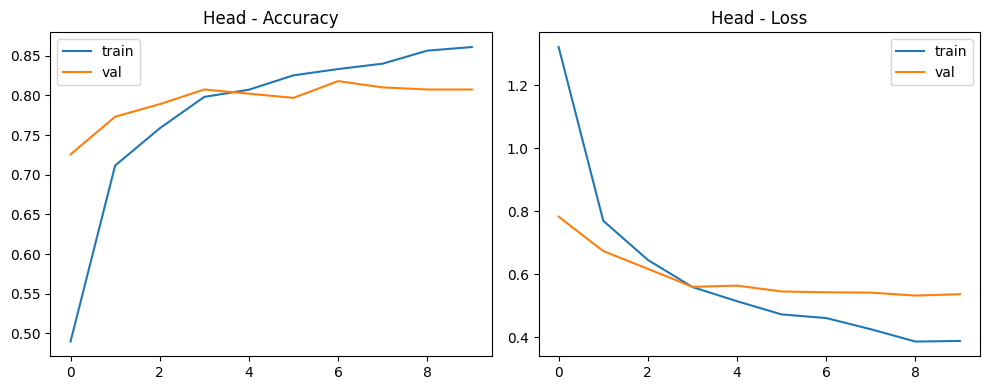

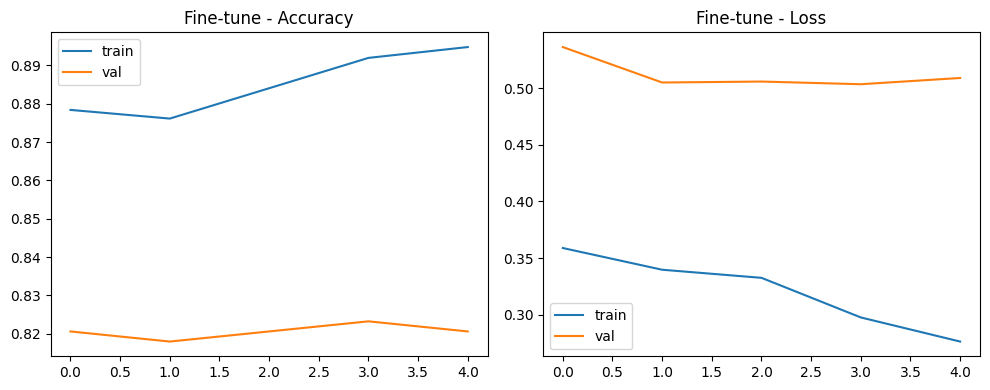

In [12]:

# curve training
def plot_history(h, title_prefix=""):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(h.history["accuracy"], label="train")
    plt.plot(h.history["val_accuracy"], label="val")
    plt.title(f"{title_prefix}Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h.history["loss"], label="train")
    plt.plot(h.history["val_loss"], label="val")
    plt.title(f"{title_prefix}Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_head, "Head - ")
if "history_ft" in globals():
    plot_history(history_ft, "Fine-tune - ")


In questo caso scelgo head perchè il finetuning non mi ha portato grandi miglioramenti

#### Scelgo modello

In [13]:
# === MANUAL CHOICE BASED ON CURVES ===
CHOSEN = "head"   # <-- cambia in "finetune" se vuoi scegliere FT
if CHOSEN == "head":
    best_tag = "head"
    best_model_path = best_head_path
    best_test_acc = test_acc_head
    best_test_loss = test_loss_head
else:
    best_tag = "finetune"
    best_model_path = best_ft_path
    best_test_acc = test_acc_ft
    best_test_loss = test_loss_ft

chosen_path = best_head_path if CHOSEN == "head" else best_ft_path
best_model = keras.models.load_model(chosen_path)

print("Chosen:", CHOSEN)
print("Model path:", chosen_path)

test_loss, test_acc = best_model.evaluate(test_ds, verbose=1)
print(f"[CHOSEN] Test acc: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# === Save run metadata (ONE JSON) ===
run_info = {
  "best_variant": CHOSEN,
  "best_model_path": str(best_model_path),
  "img_size": list(IMG_SIZE),
  "batch_size": int(BATCH_SIZE),
  "seed": int(SEED),
  "epochs_head": int(EPOCHS_HEAD),
  "epochs_finetune": int(EPOCHS_FT),
  "lr_head": float(LR_HEAD),
  "lr_finetune": float(LR_FT),
  "unfreeze_last_n": int(UNFREEZE_LAST_N),
  "test_acc_head": float(test_acc_head),
  "test_acc_finetune": float(test_acc_ft),
  "test_acc_best": float(best_test_acc),
  "test_loss_best": float(best_test_loss),
  "timestamp": STAMP,
}

run_meta_path = MODELS_DIR / f"cnn_transfer_mnv2_run_{STAMP}.json"
with open(run_meta_path, "w", encoding="utf-8") as f:
    json.dump(run_info, f, indent=2)

print("Saved run metadata:", run_meta_path)

Chosen: head
Model path: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_transfer_mnv2_head_best_2026-0206-1421.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 434ms/step - accuracy: 0.8342 - loss: 0.4981
[CHOSEN] Test acc: 0.8342 | Test loss: 0.4981
Saved run metadata: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_transfer_mnv2_run_2026-0206-1421.json


#### 8) Report + confusion matrix

              precision    recall  f1-score   support

   cardboard     0.8525    0.8667    0.8595        60
       glass     0.8272    0.8816    0.8535        76
       metal     0.7714    0.8710    0.8182        62
       paper     0.8478    0.8764    0.8619        89
     plastic     0.8615    0.7671    0.8116        73
       trash     0.9091    0.5000    0.6452        20

    accuracy                         0.8342       380
   macro avg     0.8449    0.7938    0.8083       380
weighted avg     0.8378    0.8342    0.8316       380



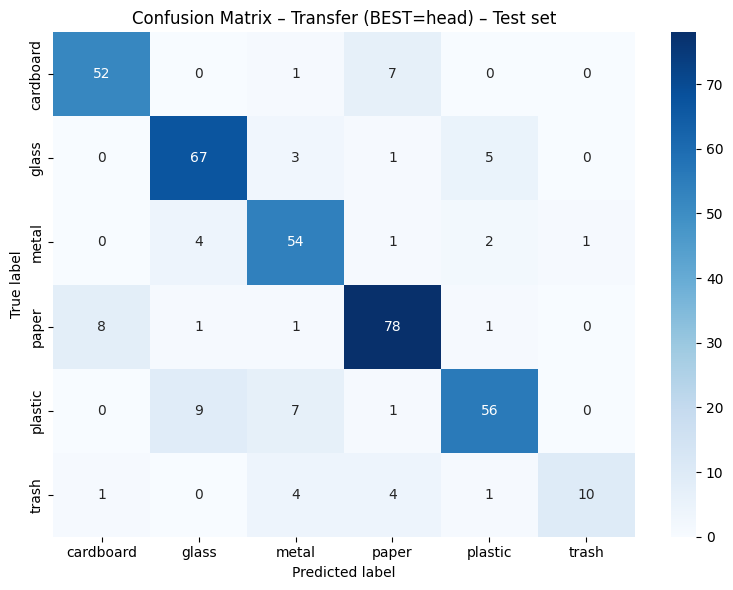

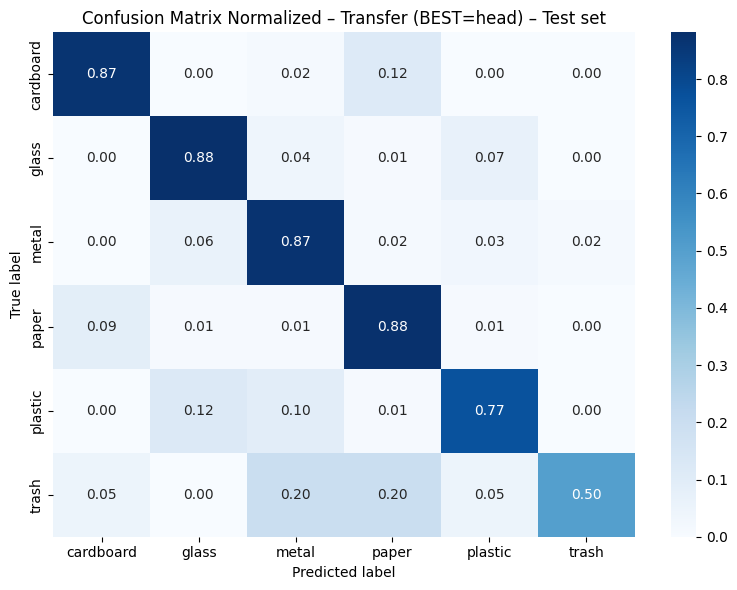

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# === Predictions on test ===
from sklearn.metrics import confusion_matrix, classification_report

y_true, y_pred = [], []

for x_batch, y_batch in test_ds:
    probs = best_model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(y_batch.numpy())
    y_pred.extend(preds)

print(classification_report(y_true, y_pred, target_names=labels, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix – Transfer (BEST={best_tag}) – Test set")
plt.tight_layout()
plt.show()

#aggiungo la versione normalizzata della confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix Normalized – Transfer (BEST={best_tag}) – Test set")
plt.tight_layout()
plt.show()


## Ricaricare il modello giusto

1) Apri il `.json` della run e leggi `best_model_path`  
2) Carica con `keras.models.load_model(best_model_path)`


In [32]:

# === Load example (da metadata) ===
# Inserisci qui il path del JSON che vuoi usare
# meta_path = MODELS_DIR / "cnn_transfer_mnv2_run_YYYYMMDD-HHMMSS.json"

# with open(meta_path, "r", encoding="utf-8") as f:
#     info = json.load(f)

# model_path = Path(info["best_model_path"])
# loaded = keras.models.load_model(model_path)
# loaded.summary()
# print("Loaded model:", model_path)
